In [1]:
import nltk
import pandas as pd
import numpy as np
import json
from collections import Counter
import re, string, unicodedata

from nltk import FreqDist

import matplotlib.pyplot as plt #For graphics
import wordcloud #Makes word clouds
import numpy as np #For divergences/distances
import scipy #For divergences/distances
import seaborn as sns 
import sklearn.manifold #For a manifold plot
import json #For API responses
import urllib.parse #For joining urls

import spacy

#Displays the graphs
import graphviz #You also need to install the command line graphviz

#These are from the standard library
import os.path
import zipfile
import subprocess
import io
import tempfile

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook
%matplotlib inline

In [2]:
try:
    nlp = spacy.load("en")
except OSError:
    nlp = spacy.load("en_core_web_sm")

# whole CDC COVID tweets

In [16]:
%store -r tweets_df

In [17]:
tweets_df

,id,date,time,username,tweet,hashtags,tokenized_tweet,normalized_tokens,year,month
0,1363921515922796547,22,13:40:04,cdcgov,covid 19 and flu can both cause fever and cou...,"[dyk, covid19]","[covid, 19, and, flu, can, both, cause, fever,...","[covid, flu, cause, fever, cough, shortness, b...",2021,02
1,1363885801755533313,22,11:18:09,cdcgov,a new looks at in georgia elementary schools t...,[covid19],"[a, new, looks, at, in, georgia, elementary, s...","[new, look, georgia, elementary, school, study...",2021,02
2,1362865816765661190,19,15:45:06,cdcgov,officials are concerned about 3 variants detec...,[covid19],"[officials, are, concerned, about, 3, variants...","[official, concern, variant, detect, u, s, b, ...",2021,02
3,1362849192130080772,19,14:39:02,cdcgov,getting a vaccine is important for adults with...,[covid19],"[getting, a, vaccine, is, important, for, adul...","[get, vaccine, important, adult, certain, heal...",2021,02
4,1362510972162867206,18,16:15:04,cdcgov,you need two mrna vaccine doses to get the mo...,"[dyk, covid19]","[you, need, two, mrna, vaccine, doses, to, get...","[need, mrna, vaccine, dose, protection, covid,...",2021,02
...,...,...,...,...,...,...,...,...,...,...
426,1233891883195211780,29,18:08:44,cdcgov,reports of community spread of in california o...,[covid19],"[reports, of, community, spread, of, in, calif...","[report, community, spread, california, oregon...",2020,02
427,1233891113628557313,29,18:05:40,cdcgov,cdc amp also reported 2 ppl have tested positi...,[covid],"[cdc, amp, also, reported, 2, ppl, have, teste...","[cdc, amp, report, ppl, test, positive, hospit...",2020,02
428,1233891108654108672,29,18:05:39,cdcgov,today and cdc reported the death of a person w...,"[covid, coronavirus]","[today, and, cdc, reported, the, death, of, a,...","[today, cdc, report, death, person, hospitaliz...",2020,02
429,1233486735578976257,28,15:18:49,cdcgov,cdc does not currently recommend the general p...,"[covid19, ppe]","[cdc, does, not, currently, recommend, the, ge...","[cdc, currently, recommend, general, public, u...",2020,02


In [18]:
#.sum() adds together the lists from each row into a single list
tweetscfdist = nltk.ConditionalFreqDist(((len(w), w) for w in tweets_df['normalized_tokens'].sum()))

#print the number of words
print(tweetscfdist.N())

8103


In [19]:
tweetscpdist = nltk.ConditionalProbDist(tweetscfdist, nltk.ELEProbDist)

#print the most common 3-16 letter word, and their probabilities
for i in range(3, 17):
    print(i)
    print(tweetscpdist[i].max())
    print(tweetscpdist[i].prob(tweetscpdist[i].max()))

3
amp
0.1541994750656168
4
case
0.055755894590846046
5
covid
0.2909457900807382
6
spread
0.116796875
7
vaccine
0.10963455149501661
8
forecast
0.05538648813146683
9
community
0.09978070175438597
10
healthcare
0.08113207547169811
11
information
0.13059701492537312
12
asymptomatic
0.08387096774193549
13
administrator
0.19318181818181818
14
recommendation
0.5740740740740741
15
hospitalization
1.0
16
disproportionate
1.0


In [20]:
def spacy_pos(word_list):
    tags = []
    doc = nlp(word_list.lower())
    for w in doc:
        tags.append((w.text, w.tag_))
    return tags

In [21]:
tweets_df['normalized_tokens_POS'] = [spacy_pos(t) for t in tweets_df['tweet']]

In [22]:
tweets_df

,id,date,time,username,tweet,hashtags,tokenized_tweet,normalized_tokens,year,month,normalized_tokens_POS
0,1363921515922796547,22,13:40:04,cdcgov,covid 19 and flu can both cause fever and cou...,"[dyk, covid19]","[covid, 19, and, flu, can, both, cause, fever,...","[covid, flu, cause, fever, cough, shortness, b...",2021,02,"[( , _SP), (covid, NNP), (19, CD), (and, CC), ..."
1,1363885801755533313,22,11:18:09,cdcgov,a new looks at in georgia elementary schools t...,[covid19],"[a, new, looks, at, in, georgia, elementary, s...","[new, look, georgia, elementary, school, study...",2021,02,"[(a, DT), (new, JJ), (looks, NNS), (at, IN), (..."
2,1362865816765661190,19,15:45:06,cdcgov,officials are concerned about 3 variants detec...,[covid19],"[officials, are, concerned, about, 3, variants...","[official, concern, variant, detect, u, s, b, ...",2021,02,"[(officials, NNS), (are, VBP), (concerned, JJ)..."
3,1362849192130080772,19,14:39:02,cdcgov,getting a vaccine is important for adults with...,[covid19],"[getting, a, vaccine, is, important, for, adul...","[get, vaccine, important, adult, certain, heal...",2021,02,"[(getting, VBG), (a, DT), (vaccine, NN), (is, ..."
4,1362510972162867206,18,16:15:04,cdcgov,you need two mrna vaccine doses to get the mo...,"[dyk, covid19]","[you, need, two, mrna, vaccine, doses, to, get...","[need, mrna, vaccine, dose, protection, covid,...",2021,02,"[( , _SP), (you, PRP), (need, VBP), (two, CD),..."
...,...,...,...,...,...,...,...,...,...,...,...
426,1233891883195211780,29,18:08:44,cdcgov,reports of community spread of in california o...,[covid19],"[reports, of, community, spread, of, in, calif...","[report, community, spread, california, oregon...",2020,02,"[(reports, NNS), (of, IN), (community, NN), (s..."
427,1233891113628557313,29,18:05:40,cdcgov,cdc amp also reported 2 ppl have tested positi...,[covid],"[cdc, amp, also, reported, 2, ppl, have, teste...","[cdc, amp, report, ppl, test, positive, hospit...",2020,02,"[(cdc, NNP), (amp, NNP), (also, RB), (reported..."
428,1233891108654108672,29,18:05:39,cdcgov,today and cdc reported the death of a person w...,"[covid, coronavirus]","[today, and, cdc, reported, the, death, of, a,...","[today, cdc, report, death, person, hospitaliz...",2020,02,"[(today, NN), (and, CC), (cdc, NNP), (reported..."
429,1233486735578976257,28,15:18:49,cdcgov,cdc does not currently recommend the general p...,"[covid19, ppe]","[cdc, does, not, currently, recommend, the, ge...","[cdc, currently, recommend, general, public, u...",2020,02,"[(cdc, NNP), (does, VBZ), (not, RB), (currentl..."


In [23]:
tweetscfdist_WordtoPOS = nltk.ConditionalFreqDist(tweets_df['normalized_tokens_POS'].sum())
tweetscfdist_POStoWord = nltk.ConditionalFreqDist((p, w) for w, p in tweets_df['normalized_tokens_POS'].sum())
tweetscfdist_POStoWord['JJ'].most_common(5) # top 5 adjectives

[('covid', 290), ('new', 102), ('national', 27), ('sick', 25), ('many', 25)]

In [24]:
tweetscfdist_POStoWord['NN']

FreqDist({'spread': 100, 'amp': 76, 'vaccine': 64, 'health': 58, 'update': 46, 'risk': 44, 'mask': 40, 'week': 37, 'call': 35, 'report': 34, ...})

In [25]:
tweetscfdist_POStoWord['VB']

FreqDist({'be': 71, 'help': 68, 'learn': 54, 'protect': 36, 'have': 33, 'slow': 32, 'prevent': 27, 'stay': 26, 'wear': 23, 'spread': 23, ...})

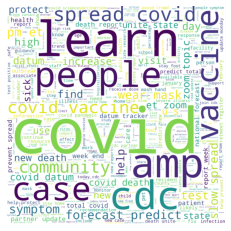

In [26]:
wc = wordcloud.WordCloud(background_color="white", max_words=500, width= 3000, height = 3000, mode ='RGBA', scale=.5).generate(' '.join(tweets_df['normalized_tokens'].sum()))
plt.imshow(wc)
plt.axis("off")
plt.savefig("covid_tweets_word_cloud.pdf", format = 'pdf')

In [42]:
def sent_tokenize(word_list):
    doc = nlp(word_list)
    sentences = [sent.string.strip() for sent in doc.sents]
    return sentences

In [44]:
def word_tokenize(word_list, model=nlp, MAX_LEN=1500000):   
    tokenized = []
    if type(word_list) == list and len(word_list) == 1:
        word_list = word_list[0]

    if type(word_list) == list:
        word_list = ' '.join([str(elem) for elem in word_list]) 
    # since we're only tokenizing, I remove RAM intensive operations and increase max text size

    model.max_length = MAX_LEN
    doc = model(word_list, disable=["parser", "tagger", "ner"])
    
    for token in doc:
        if not token.is_punct and len(token.text.strip()) > 0:
            tokenized.append(token.text)
    return tokenized

In [45]:
tweets_df['sentences'] = tweets_df['tweet'].apply(lambda x: [word_tokenize(s) for s in sent_tokenize(x)])

In [46]:
def tag_sents_pos(sentences):
    """
    function which replicates NLTK pos tagging on sentences.
    """
    new_sents = []
    for sentence in sentences:
        new_sent = ' '.join(sentence)
        new_sents.append(new_sent)
    final_string = ' '.join(new_sents)
    doc = nlp(final_string)
    
    pos_sents = []
    for sent in doc.sents:
        pos_sent = []
        for token in sent:
            pos_sent.append((token.text, token.tag_))
        pos_sents.append(pos_sent)
    
    return pos_sents

In [47]:
tweets_df['POS_sents'] = tweets_df['sentences'].apply(lambda x: tag_sents_pos(x))

In [175]:
#count the number of VB (verbs)
countTarget = 'VB'
targetCounts = {}
for entry in tweets_df['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
verb_noun_sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
verb_noun_sortedTargets[:20]

[('be', 71),
 ('help', 68),
 ('learn', 54),
 ('protect', 36),
 ('have', 33),
 ('slow', 32),
 ('prevent', 27),
 ('stay', 26),
 ('wear', 23),
 ('spread', 23),
 ('take', 19),
 ('get', 17),
 ('know', 16),
 ('see', 15),
 ('stop', 14),
 ('reduce', 13),
 ('keep', 12),
 ('wash', 11),
 ('join', 10),
 ('make', 9)]

In [172]:
#count the number of NN (nouns)
countTarget = 'NN'
targetCounts = {}
for entry in tweets_df['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
noun_sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
noun_sortedTargets[:20]

[('spread', 100),
 ('amp', 76),
 ('vaccine', 64),
 ('health', 58),
 ('update', 46),
 ('risk', 44),
 ('pm', 41),
 ('mask', 40),
 ('week', 37),
 ('call', 35),
 ('report', 34),
 ('community', 29),
 ('pandemic', 28),
 ('contact', 26),
 ('total', 26),
 ('virus', 26),
 ('illness', 25),
 ('cdcs', 24),
 ('zoom', 24),
 ('care', 22)]

In [156]:
def get_modify_word(NTarget, Word):
    NResults = set()
    for entry in tweets_df['POS_sents']:
        for sentence in entry:
            for (ent1, kind1),(ent2,kind2) in zip(sentence[:-2], sentence[2:]):
                if (kind1,ent2.lower())==(NTarget,Word):
                    NResults.add(ent1)
                else:
                    continue
    return NResults

In [171]:
print(get_modify_word("VB", "mask"))
print(get_modify_word("VB", "hands"))
print(get_modify_word("VB", "distance"))
print(get_modify_word("JJ", "zoom"))
print(get_modify_word("VB", ""))

{'wear', 'position', 'put'}
{'wash'}
{'keep'}
{'available'}
set()


In [173]:
#the adjectives that modify the noun
r_jj = {}
for i, v in noun_sortedTargets[:20]:
    #print(i)
    r_jj[i] = get_modify_word("JJ", str(i))
r_jj

{'spread': {'covid', 'likely', 'long', 'rapid', 'slow', 'unlikely'},
 'amp': {'covid', 'key', 'many', 'mental', 'serious', 'sick', 'updated'},
 'vaccine': {'annual', 'covid', 'respiratory', 'variant'},
 'health': {'local', 'national', 'telehealth'},
 'update': set(),
 'risk': {'little'},
 'pm': set(),
 'mask': {'mental'},
 'week': {'public'},
 'call': {'next'},
 'report': {'likely'},
 'community': {'rural'},
 'pandemic': {'covid'},
 'contact': {'covid', 'diagnostic', 'second', 'sick'},
 'total': set(),
 'virus': {'covid'},
 'illness': {'covid', 'sick'},
 'cdcs': {'covid', 'different', 'new', 'pandemic', 'rural', 'widespread'},
 'zoom': {'available'},
 'care': {'covid', 'long'}}

In [174]:
#the verbs that modify the noun
r_vb = {}
for i, v in noun_sortedTargets[:20]:
    r_vb[i] = get_modify_word("VB", str(i))
r_vb

{'spread': {'decrease', 'limit', 'lower', 'prevent', 'reduce', 'slow', 'stop'},
 'amp': {'have', 'make', 'protect', 'screen'},
 'vaccine': {'get'},
 'health': set(),
 'update': set(),
 'risk': {'be', 'pose', 'reduce'},
 'pm': set(),
 'mask': {'position', 'put', 'wear'},
 'week': set(),
 'call': {'answer'},
 'report': {'be', 'collect'},
 'community': {'report'},
 'pandemic': {'stop'},
 'contact': {'identify'},
 'total': set(),
 'virus': {'fight', 'prevent', 'spread'},
 'illness': {'cause', 'have', 'look'},
 'cdcs': {'learn', 'subscribe'},
 'zoom': set(),
 'care': {'get', 'take'}}

In [122]:
def find_part_relation(part1, part2, content):
    NResults = []
    for entry in content:
        for sentence in entry:
            for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
                if (kind1 == part1 and kind2 == part2) or  (kind1 == part2 and kind2 == part1):
                    NResults.append([ent1,ent2])
                else:
                    continue
    return NResults
adj_noun_pairs = find_part_relation('JJ','NN',tweets_df['POS_sents'])
adj_noun_pairs[:10]

[['important', 'part'],
 ['certain', 'health'],
 ['bad', 'reaction'],
 ['second', 'dose'],
 ['second', 'dose'],
 ['first', 'appointment'],
 ['new', 'report'],
 ['current', 'vaccine'],
 ['adolescent', 'immunization'],
 ['real', 'world']]

In [123]:
adj_noun_pairs = find_part_relation('VB','NN',tweets_df['POS_sents'])
adj_noun_pairs[:10]

[['cause', 'fever'],
 ['share', 'information'],
 ['ensure', 'access'],
 ['support', 'implementation'],
 ['spread', 'wear'],
 ['mask', 'stay'],
 ['find', 'information'],
 ['week', 'see'],
 ['affect', 'pregnancy'],
 ['take', 'part']]

In [137]:
def find_part_relation(part1, part2, content):
    NResults = []
    for entry in content:
        for sentence in entry:
            for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
                if (kind1 == part1 and kind2 == part2)or  (kind1 == part2 and kind2 == part1):
                    NResults.append([ent1,ent2])
                else:
                    continue
    return NResults
adj_noun_pairs = find_part_relation('VB','RB',tweets_df['POS_sents'])
adj_noun_pairs[:20]

[['get', 'very'],
 ['nt', 'miss'],
 ['apart', 'avoid'],
 ['nt', 'live'],
 ['not', 'be'],
 ['safely', 'get'],
 ['nt', 'live'],
 ['apart', 'wash'],
 ['also', 'continue'],
 ['increase', 'nationwide'],
 ['also', 'remind'],
 ['nt', 'know'],
 ['not', 'require'],
 ['get', 'very'],
 ['sometimes', 'require'],
 ['spread', 'anywhere'],
 ['out', 'wear'],
 ['keep', 'at'],
 ['spread', 'anywhere'],
 ['go', 'out']]

In [178]:
#bigrams
tweetsBigrams = nltk.collocations.BigramCollocationFinder.from_words(tweets_df['normalized_tokens'].sum())
print("There are {} bigrams in the finder".format(tweetsBigrams.N))

def bigramScoring(count, wordsTuple, total):
    return count

print(tweetsBigrams.nbest(bigramScoring, 10))

There are 8103 bigrams in the finder
[('spread', 'covid'), ('covid', 'vaccine'), ('forecast', 'predict'), ('pm', 'et'), ('wear', 'mask'), ('slow', 'spread'), ('zoom', 'topic'), ('covid', 'datum'), ('et', 'zoom'), ('new', 'death')]


In [180]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
tweetsBigrams.score_ngrams(bigram_measures.likelihood_ratio)[:20]

[(('pm', 'et'), 479.20767177922255),
 (('forecast', 'predict'), 466.3809503172099),
 (('wear', 'mask'), 336.5773712581846),
 (('zoom', 'topic'), 316.08858308328115),
 (('u', 's'), 292.3521048087795),
 (('et', 'zoom'), 275.3959724906283),
 (('slow', 'spread'), 263.70097594496195),
 (('unite', 'state'), 245.6096618759106),
 (('retweet', 'register'), 228.91414207132664),
 (('week', 'end'), 227.09135489809165),
 (('wash', 'hand'), 226.7263398623804),
 (('partner', 'update'), 211.41295089609773),
 (('national', 'forecast'), 209.5582416064235),
 (('datum', 'tracker'), 201.83844801597903),
 (('predict', 'total'), 194.56860823976353),
 (('avoid', 'crowd'), 167.94714175026724),
 (('update', 'monday'), 154.2756105838855),
 (('spread', 'covid'), 144.7397210242181),
 (('racial', 'ethnic'), 141.52198596843647),
 (('stay', 'foot'), 140.57193864874745)]

In [181]:
[s for s in dir(bigram_measures) if s[0] != '_']

['chi_sq',
 'dice',
 'fisher',
 'jaccard',
 'likelihood_ratio',
 'mi_like',
 'phi_sq',
 'pmi',
 'poisson_stirling',
 'raw_freq',
 'student_t']

In [184]:
trigram_measures = nltk.collocations.TrigramAssocMeasures()
tweetsTrigrams = nltk.collocations.TrigramCollocationFinder.from_words(tweets_df['normalized_tokens'].sum())
tweetsTrigrams.score_ngrams(trigram_measures.student_t)[:20]

[(('et', 'zoom', 'topic'), 4.898854527605498),
 (('pm', 'et', 'zoom'), 4.898824234766502),
 (('total', 'covid', 'death'), 4.6866844409467445),
 (('report', 'week', 'end'), 4.582123429960349),
 (('death', 'report', 'week'), 4.581348118539508),
 (('covid', 'datum', 'tracker'), 4.579867130149512),
 (('new', 'death', 'report'), 4.579656791032561),
 (('national', 'forecast', 'predict'), 4.47194040558843),
 (('forecast', 'predict', 'total'), 4.471933662505287),
 (('predict', 'total', 'covid'), 4.469870279063509),
 (('forecast', 'predict', 'new'), 4.358158690006246),
 (('predict', 'new', 'death'), 4.357648737571418),
 (('slow', 'spread', 'covid'), 4.230509553445714),
 (('death', 'unite', 'state'), 3.999576354107654),
 (('covid', 'death', 'unite'), 3.996499712627174),
 (('partner', 'update', 'monday'), 3.872889262453111),
 (('prevent', 'spread', 'covid'), 3.8629427751372716),
 (('cdc', 'partner', 'update'), 3.4634143814150833),
 (('covid', 'science', 'update'), 3.4621516317670213),
 (('help', 

In [187]:
Ngrams = nltk.ngrams(tweets_df['normalized_tokens'].sum(), 4)
Counts = {}
for ngram in list(Ngrams):
    if ngram in Counts.keys():
        Counts[ngram] += 1
    else:
        Counts[ngram] = 1
Filtered = {}
for key in Counts.keys():
    if Counts[key] < 2:
        pass
    else:
        Filtered[key] = Counts[key]
print(Filtered)

{('fever', 'cough', 'shortness', 'breath'): 2, ('use', 'chart', 'learn', 'similarity'): 2, ('chart', 'learn', 'similarity', 'difference'): 2, ('learn', 'covid', 'science', 'update'): 2, ('cdcs', 'new', 'covid', 'datum'): 2, ('new', 'covid', 'datum', 'tracker'): 2, ('covid', 'datum', 'tracker', 'weekly'): 3, ('datum', 'tracker', 'weekly', 'review'): 3, ('protect', 'get', 'sick', 'covid'): 2, ('covid', 'february', 'people', 'receive'): 2, ('february', 'people', 'receive', 'dose'): 3, ('people', 'receive', 'dose', 'covid'): 8, ('receive', 'dose', 'covid', 'vaccine'): 8, ('dose', 'covid', 'vaccine', 'people'): 2, ('covid', 'vaccine', 'people', 'receive'): 2, ('vaccine', 'people', 'receive', 'dose'): 2, ('people', 'receive', 'dose', 'amp'): 2, ('receive', 'dose', 'amp', 'fully'): 2, ('dose', 'amp', 'fully', 'vaccinate'): 2, ('vaccine', 'help', 'protect', 'get'): 2, ('key', 'slow', 'spread', 'covid'): 2, ('slow', 'spread', 'covid', 'public'): 2, ('spread', 'covid', 'public', 'health'): 2, ('

In [198]:
import keras
skipgrams = keras.preprocessing.sequence.skipgrams(tweets_df['normalized_tokens'].sum(), 2000, 2,
                                                        negative_samples=0, shuffle=True, 
                                                        categorical=False, sampling_table=None, seed=None)

In [201]:
skip_con = nltk.ConditionalFreqDist(skipgrams[0])
list(skip_con.items())

[('learn',
  FreqDist({'covid': 56, 'spread': 24, 'case': 15, 'cdc': 13, 'new': 13, 'people': 12, 'illness': 9, 'find': 9, 'school': 8, 'vaccine': 8, ...})),
 ('respond',
  FreqDist({'prepare': 3, 'plan': 3, 'community': 2, 'covid': 2, 'indicator': 2, 'provide': 2, 'identify': 1, 'case': 1, 'visit': 1, 'learn': 1, ...})),
 ('attempt', FreqDist({'fraud': 1, 'involve': 1, 'scam': 1, 'victim': 1})),
 ('group',
  FreqDist({'ethnic': 11, 'age': 7, 'racial': 7, 'high': 6, 'minority': 6, 'risk': 5, 'affect': 4, 'case': 2, 'factor': 2, 'covid': 2, ...})),
 ('spread',
  FreqDist({'covid': 82, 'slow': 38, 'help': 28, 'learn': 24, 'prevent': 22, 'people': 15, 'virus': 12, 'symptom': 12, 'community': 11, 'mask': 10, ...})),
 ('february',
  FreqDist({'forecast': 5, 'state': 4, 'predict': 4, 'update': 4, 'end': 4, 'week': 4, 'unite': 4, 'receive': 3, 'covid': 3, 'monday': 3, ...})),
 ('partner',
  FreqDist({'cdc': 26, 'update': 23, 'monday': 15, 'covid': 11, 'join': 7, 'pm': 6, 'today': 5, 'informat

In [204]:
def tag_sents_ner(sentences):
    """
    function which replicates NLTK ner tagging on sentences.
    """
    new_sents = []
    for sentence in sentences:
        new_sent = ' '.join(sentence)
        new_sents.append(new_sent)
    final_string = ' '.join(new_sents)
    doc = nlp(final_string)
    
    pos_sents = []
    for sent in doc.sents:
        pos_sent = []
        for ent in sent.ents:
            pos_sent.append((ent.text, ent.label_))
        pos_sents.append(pos_sent)
    
    return pos_sents

In [205]:
tweets_df['classified_sents'] = tweets_df['sentences'].apply(lambda x: tag_sents_ner(x))

In [206]:
tweets_df

,id,date,time,username,tweet,hashtags,tokenized_tweet,normalized_tokens,normalized_tokens_POS,sentences,POS_sents,classified_sents
0,1363921515922796547,2021-02-22,13:40:04,cdcgov,covid 19 and flu can both cause fever and cou...,"[dyk, covid19]","[covid, 19, and, flu, can, both, cause, fever,...","[covid, flu, cause, fever, cough, shortness, b...","[( , _SP), (covid, NNP), (19, CD), (and, CC), ...","[[covid, 19, and, flu, can, both, cause, fever...","[[(covid, NNP), (19, CD), (and, CC), (flu, NN)...","[[(covid 19, PERSON)], [(19, CARDINAL)]]"
1,1363885801755533313,2021-02-22,11:18:09,cdcgov,a new looks at in georgia elementary schools t...,[covid19],"[a, new, looks, at, in, georgia, elementary, s...","[new, look, georgia, elementary, school, study...","[(a, DT), (new, JJ), (looks, NNS), (at, IN), (...","[[a, new, looks, at, in, georgia, elementary, ...","[[(a, DT), (new, JJ), (looks, NNS), (at, IN), ...","[[(georgia, GPE), (19, CARDINAL)]]"
2,1362865816765661190,2021-02-19,15:45:06,cdcgov,officials are concerned about 3 variants detec...,[covid19],"[officials, are, concerned, about, 3, variants...","[official, concern, variant, detect, u, s, b, ...","[(officials, NNS), (are, VBP), (concerned, JJ)...","[[officials, are, concerned, about, 3, variant...","[[(officials, NNS), (are, VBP), (concerned, JJ...","[[(about 3, CARDINAL), (the u s, GPE)], [(uk, ..."
3,1362849192130080772,2021-02-19,14:39:02,cdcgov,getting a vaccine is important for adults with...,[covid19],"[getting, a, vaccine, is, important, for, adul...","[get, vaccine, important, adult, certain, heal...","[(getting, VBG), (a, DT), (vaccine, NN), (is, ...","[[getting, a, vaccine, is, important, for, adu...","[[(getting, VBG), (a, DT), (vaccine, NN), (is,...","[[(19, CARDINAL), (19, CARDINAL)]]"
4,1362510972162867206,2021-02-18,16:15:04,cdcgov,you need two mrna vaccine doses to get the mo...,"[dyk, covid19]","[you, need, two, mrna, vaccine, doses, to, get...","[need, mrna, vaccine, dose, protection, covid,...","[( , _SP), (you, PRP), (need, VBP), (two, CD),...","[[you, need, two, mrna, vaccine, doses, to, ge...","[[(you, PRP), (need, VBP), (two, CD), (mrna, N...","[[(two, CARDINAL), (mrna, GPE), (19, CARDINAL)..."
...,...,...,...,...,...,...,...,...,...,...,...,...
426,1233891883195211780,2020-02-29,18:08:44,cdcgov,reports of community spread of in california o...,[covid19],"[reports, of, community, spread, of, in, calif...","[report, community, spread, california, oregon...","[(reports, NNS), (of, IN), (community, NN), (s...","[[reports, of, community, spread, of, in, cali...","[[(reports, NNS), (of, IN), (community, NN), (...","[[(california, GPE), (oregon, GPE), (washingto..."
427,1233891113628557313,2020-02-29,18:05:40,cdcgov,cdc amp also reported 2 ppl have tested positi...,[covid],"[cdc, amp, also, reported, 2, ppl, have, teste...","[cdc, amp, report, ppl, test, positive, hospit...","[(cdc, NNP), (amp, NNP), (also, RB), (reported...","[[cdc, amp, also, reported, 2, ppl, have, test...","[[(cdc, NNP), (amp, NNP), (also, RB), (reporte...","[[(cdc amp, ORG), (2, CARDINAL), (19, CARDINAL..."
428,1233891108654108672,2020-02-29,18:05:39,cdcgov,today and cdc reported the death of a person w...,"[covid, coronavirus]","[today, and, cdc, reported, the, death, of, a,...","[today, cdc, report, death, person, hospitaliz...","[(today, NN), (and, CC), (cdc, NNP), (reported...","[[today, and, cdc, reported, the, death, of, a...","[[(today, NN), (and, CC), (cdc, NNP), (reporte...","[[(today, DATE), (cdc, ORG), (19, CARDINAL)], ..."
429,1233486735578976257,2020-02-28,15:18:49,cdcgov,cdc does not currently recommend the general p...,"[covid19, ppe]","[cdc, does, not, currently, recommend, the, ge...","[cdc, currently, recommend, general, public, u...","[(cdc, NNP), (does, VBZ), (not, RB), (currentl...","[[cdc, does, not, currently, recommend, the, g...","[[(cdc, NNP), (does, VBZ), (not, RB), (current...","[[(cdc, ORG), (2017, DATE), (19, CARDINAL)]]"


In [222]:
entityCounts = {}
for entry in tweets_df['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if ent in entityCounts:
                entityCounts[ent] += 1
            else:
                entityCounts[ent] = 1
sortedEntities = sorted(entityCounts.items(), key = lambda x: x[1], reverse = True)
sortedEntities[:90]

[('19', 460),
 ('cdc', 60),
 ('us', 28),
 ('the united states', 24),
 ('3 pm', 20),
 ('first', 17),
 ('2 pm', 15),
 ('one', 14),
 ('daily', 10),
 ('the u s', 9),
 ('6 feet', 9),
 ('3', 8),
 ('today', 8),
 ('two', 7),
 ('the last 7 days', 7),
 ('6', 7),
 ('todays', 7),
 ('covid 19', 6),
 ('weekly', 6),
 ('at least 6 feet', 6),
 ('1', 6),
 ('2019', 6),
 ('2', 5),
 ('5', 5),
 ('50', 5),
 ('u s', 5),
 ('hispanic', 5),
 ('march', 5),
 ('12', 5),
 ('7 day', 5),
 ('mrna', 4),
 ('second', 4),
 ('10', 4),
 ('a3', 4),
 ('2020 2021', 4),
 ('the last week', 4),
 ('6 ft', 4),
 ('american', 4),
 ('indian', 4),
 ('john brooks', 4),
 ('clinician', 3),
 ('january 4', 3),
 ('cdc covid 19', 3),
 ('100', 3),
 ('14', 3),
 ('spanish', 3),
 ('the coming weeks', 3),
 ('california', 3),
 ('uk', 2),
 ('2021', 2),
 ('1st', 2),
 ('this weeks', 2),
 ('february 1', 2),
 ('monday february 1', 2),
 ('three', 2),
 ('fda', 2),
 ('hcps', 2),
 ('ten', 2),
 ('this season', 2),
 ('the previous 7 days', 2),
 ('house', 2),
 

# quarter 1, 2020

In [3]:
%store -r tweets01

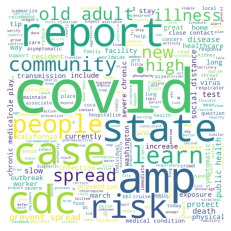

In [6]:
wc = wordcloud.WordCloud(background_color="white", max_words=500, width= 3000, height = 3000, mode ='RGBA', scale=.5).generate(' '.join(tweets01['normalized_tokens'].sum()))
plt.imshow(wc)
plt.axis("off")
plt.savefig("covid_tweets_01_word_cloud.pdf", format = 'pdf')

# quarter 2, 2020

In [7]:
%store -r tweets02

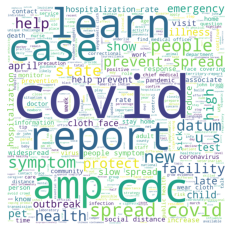

In [8]:
wc = wordcloud.WordCloud(background_color="white", max_words=500, width= 3000, height = 3000, mode ='RGBA', scale=.5).generate(' '.join(tweets02['normalized_tokens'].sum()))
plt.imshow(wc)
plt.axis("off")
plt.savefig("covid_tweets_02_word_cloud.pdf", format = 'pdf')

# quarter 3, 2020

In [9]:
%store -r tweets03

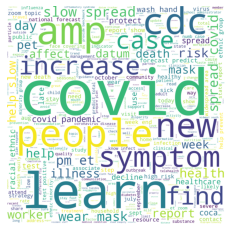

In [10]:
wc = wordcloud.WordCloud(background_color="white", max_words=500, width= 3000, height = 3000, mode ='RGBA', scale=.5).generate(' '.join(tweets03['normalized_tokens'].sum()))
plt.imshow(wc)
plt.axis("off")
plt.savefig("covid_tweets_03_word_cloud.pdf", format = 'pdf')

# quarter 4, 2020

In [11]:
%store -r tweets04

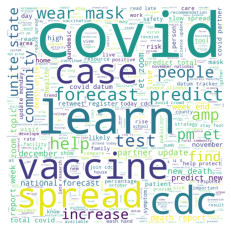

In [12]:
wc = wordcloud.WordCloud(background_color="white", max_words=500, width= 3000, height = 3000, mode ='RGBA', scale=.5).generate(' '.join(tweets04['normalized_tokens'].sum()))
plt.imshow(wc)
plt.axis("off")
plt.savefig("covid_tweets_04_word_cloud.pdf", format = 'pdf')

# quarter 1, 2021

In [14]:
%store -r tweets0121

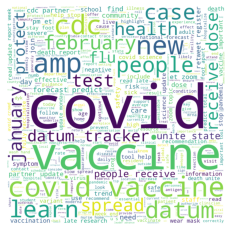

In [15]:
wc = wordcloud.WordCloud(background_color="white", max_words=500, width= 3000, height = 3000, mode ='RGBA', scale=.5).generate(' '.join(tweets0121['normalized_tokens'].sum()))
plt.imshow(wc)
plt.axis("off")
plt.savefig("covid_tweets_01_21_word_cloud.pdf", format = 'pdf')